In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/MyDrive/twitter_sentiment')

## Install Packages

In [ ]:
!pip install nltk
!pip install emot==3.1

## Import Packages

In [ ]:
import nltk
nltk.download(['punkt', 'stopwords'])

In [5]:
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

## Load Data

In [7]:
STOPWORDS_FILEPATH = "data/stop_words.txt"
SAVE_WORD_CLOUD_FILEPATH = "results/yzsb_v2/Yapay Zeka Stratejisi_2021-08-20_2021-08-25_{0}_wordcloud_v2_freq.png"

In [8]:
df = pd.read_csv("data/Yapay_Zeka_Stratejisi_2021_08_20_2021_08_25_df_sentiment_analysis_all.csv")
df

,Unnamed: 0,Unnamed: 0.1,id,created_at,date,time,tweet,sentiment_label,sentiment_score
0,0,0,1430303911487762438,2021-08-24 23:00:00+00:00,2021-08-24,23:00:00,Türkiye'nin Yapay Zeka Stratejisi... Ulusal Ya...,negative,0.6704
1,1,1,1430296179934470146,2021-08-24 22:29:17+00:00,2021-08-24,22:29:17,Açıklanan Türkiye Yapay Zeka Stratejisi ile il...,positive,0.9017
2,2,2,1430291373366857736,2021-08-24 22:10:11+00:00,2021-08-24,22:10:11,@ZB6868 @firstjedii @varank Bence biraz absürd...,positive,0.9990
3,3,3,1430289767976116229,2021-08-24 22:03:48+00:00,2021-08-24,22:03:48,Türkiye’nin İlk Ulusal Yapay Zeka Stratejisi a...,positive,0.5813
4,4,4,1430279189106675716,2021-08-24 21:21:46+00:00,2021-08-24,21:21:46,Türkiye'nin İlk Ulusal Yapay Zeka Stratejisi a...,negative,0.6870
...,...,...,...,...,...,...,...,...,...
657,657,657,1428589924807217157,2021-08-20 05:29:14+00:00,2021-08-20,05:29:14,Bugünkü resmi gazete ile “Ulusal Yapay Zeka S...,negative,0.7368
658,658,658,1428583261966684161,2021-08-20 05:02:46+00:00,2021-08-20,05:02:46,Bugünkü Resmi Gazete'de (20.08.2021 T-31574 sa...,negative,0.8500
659,659,659,1428574478536151042,2021-08-20 04:27:51+00:00,2021-08-20,04:27:51,Ulusal Yapay Zekâ Stratejisi (2021-2025) ile İ...,negative,0.7597
660,660,660,1428569701056122883,2021-08-20 04:08:52+00:00,2021-08-20,04:08:52,Yapay zeka alanında çalışan arkadaşlar için ön...,positive,0.9103


In [9]:
df_positive = pd.read_csv("data/Yapay_Zeka_Stratejisi_2021_08_20_2021_08_25_df_sentiment_analysis_positive.csv")
df_positive

,Unnamed: 0,Unnamed: 0.1,id,created_at,date,time,tweet,sentiment_label,sentiment_score
0,2,2,1430291373366857736,2021-08-24 22:10:11+00:00,2021-08-24,22:10:11,@ZB6868 @firstjedii @varank Bence biraz absürd...,positive,0.9990
1,11,11,1430266493892276225,2021-08-24 20:31:19+00:00,2021-08-24,20:31:19,"Türkiye, yapay zekâ stratejisini yayımlayan ül...",positive,0.9763
2,16,16,1430249798922346500,2021-08-24 19:24:59+00:00,2021-08-24,19:24:59,"Ulusal Yapay Zeka Stratejisi Programı, savunma...",positive,0.9746
3,20,20,1430246235554951171,2021-08-24 19:10:49+00:00,2021-08-24,19:10:49,#YapayZekaÇağı başlıyor 📣 🇹🇷 @udijital ve @TC...,positive,0.9616
4,26,26,1430234962431729669,2021-08-24 18:26:02+00:00,2021-08-24,18:26:02,YAPAY ZEKA ÇAĞI @dijital ile @TCSanayi işbir...,positive,0.9614
...,...,...,...,...,...,...,...,...,...
69,581,581,1428626061311594500,2021-08-20 07:52:50+00:00,2021-08-20,07:52:50,🇹🇷Türkiye'nin 2021-2025 Ulusal Yapay Zeka Stra...,positive,0.9887
70,586,586,1428622499676397577,2021-08-20 07:38:41+00:00,2021-08-20,07:38:41,🧠 Ulusal Yapay Zeka Stratejisi 24 Ağustos'ta Y...,positive,0.9581
71,595,595,1428617623156273158,2021-08-20 07:19:18+00:00,2021-08-20,07:19:18,Kısa fıkra: Türkiye'nin yapay zeka stratejisi...,positive,0.9728
72,614,614,1428609046337228800,2021-08-20 06:45:13+00:00,2021-08-20,06:45:13,Türkiye'nin yapay zeka stratejisi belirlendi ...,positive,0.9842


In [10]:
df_negative = pd.read_csv("data/Yapay_Zeka_Stratejisi_2021_08_20_2021_08_25_df_sentiment_analysis_negative.csv")
df_negative

,Unnamed: 0,Unnamed: 0.1,id,created_at,date,time,tweet,sentiment_label,sentiment_score
0,5,5,1430277484822421504,2021-08-24 21:15:00+00:00,2021-08-24,21:15:00,Füsun Sarp Nebil yazdı: Yapay zekâ stratejisi...,negative,0.9978
1,14,14,1430255053424693256,2021-08-24 19:45:52+00:00,2021-08-24,19:45:52,Sabırla dinledim konuşmaları ve çok sığ buldum...,negative,0.9994
2,35,35,1430212749519429635,2021-08-24 16:57:46+00:00,2021-08-24,16:57:46,1 Yıl Önce de 1 Milyon Yazılımcı Yetiştireceği...,negative,0.9987
3,59,59,1430173539391451138,2021-08-24 14:21:57+00:00,2021-08-24,14:21:57,Yapay zeka stratejisi dokümanına bakıyorduk. Y...,negative,0.9912
4,105,105,1430127840532570115,2021-08-24 11:20:22+00:00,2021-08-24,11:20:22,Yapay zeka stratejisi güzel bir girişim olabil...,negative,0.9887
5,219,219,1430086544736538663,2021-08-24 08:36:16+00:00,2021-08-24,08:36:16,"Sizden, 'Ulusal yapay zeka' degil, ancak, 'Ulu...",negative,0.9867
6,221,221,1430085795017330688,2021-08-24 08:33:17+00:00,2021-08-24,08:33:17,Ulusal Yapay Zeka Stratejisi/ İthal Yapay Zeka...,negative,0.9813
7,223,223,1430084739973664779,2021-08-24 08:29:06+00:00,2021-08-24,08:29:06,#YapayZekaÇağı na Hazırlanan ve amacı öncüleri...,negative,0.9688
8,250,250,1430077077462659072,2021-08-24 07:58:39+00:00,2021-08-24,07:58:39,Ulusal Yapay Zeka Stratejisi diye bakan Varank...,negative,0.9989
9,255,255,1430075226814128136,2021-08-24 07:51:18+00:00,2021-08-24,07:51:18,@erdl1971 Tribüne oynama temalı yapay zeka str...,negative,0.9905


## Preprocess 

In [11]:
import re
import sys
from nltk.stem.porter import PorterStemmer
from emot.emo_unicode import UNICODE_EMOJI
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [13]:
def get_stopwords_list():
    s_words = []
    w_file = open(STOPWORDS_FILEPATH, encoding="utf-8")
    
    for word in w_file:
        word = word.strip()
        
        s_words.append(word)

    s_words.append("•")
    s_words.append("20212025")
    s_words.append("saat")
    s_words.append("10.00da")
    s_words.append("nde")

    w_file.close()

    return s_words

In [14]:
# https://medium.com/geekculture/text-preprocessing-how-to-handle-emoji-emoticon-641bbfa6e9e7


##Torku Konyaspor silinecek

def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;``')
    
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)|😉', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)

    return tweet


def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', string)


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    
    #Clean only digits
    tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet)
    
    # Replaces URLs with the word URL
    #tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', tweet)
    
    # Replace @handle with the word USER_MENTION
    #tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    tweet = re.sub(r'@[\S]+', '', tweet)
    
    # Replaces #hashtag with hashtag
    #tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    tweet = re.sub(r'#(\S+)', '', tweet)
    
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')

    # Replace emojis with either EMO_POS or EMO_NEG
    #tweet = handle_emojis(tweet)
    tweet = remove_emoji(tweet)
   
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)

    #my custom chars
    tweet = tweet.replace('₺','')
    tweet = tweet.replace('=','')
    tweet = tweet.replace('’','')
    tweet = tweet.replace('|','')
    tweet = tweet.replace('‘','')
    tweet = tweet.replace('/','')
    tweet = tweet.replace('…','')
    tweet = tweet.replace('–','')
    tweet = tweet.replace('&','')
    tweet = tweet.replace('“','')
    tweet = tweet.replace('”','')
    tweet = tweet.replace('+','')
    tweet = tweet.replace('%','')
    tweet = tweet.replace('@','')
    tweet = tweet.replace('#','')
    tweet = tweet.replace('i̇','i')

    words = word_tokenize(tweet) #tweet.split()

    for word in words:
      word = preprocess_word(word)
      #if is_valid_word(word):
      #    processed_tweet.append(word)
      processed_tweet.append(word)

    return ' '.join(processed_tweet)

## Generate Word Cloud

In [16]:
def generate_word_cloud_from_frequencies(freq_dict, status):
    
    # adding movie script specific stopwords
    stop_words = get_stopwords_list()

    #print(stop_words)

    #print(len(fdist_filtered))

    wordcloud = WordCloud(
        width=1200, 
        height=800, 
        background_color="black", 
        max_words=200, 
        min_font_size=10,
        stopwords = stop_words).generate_from_frequencies(frequencies=freq_dict)
    
    plt.figure(figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

    wordcloud.to_file(SAVE_WORD_CLOUD_FILEPATH.format(status))

In [17]:
stop_words = get_stopwords_list()
len(stop_words)

315

## ALL

In [18]:
df.tweet

0      Türkiye'nin Yapay Zeka Stratejisi... Ulusal Ya...
1      Açıklanan Türkiye Yapay Zeka Stratejisi ile il...
2      @ZB6868 @firstjedii @varank Bence biraz absürd...
3      Türkiye’nin İlk Ulusal Yapay Zeka Stratejisi a...
4      Türkiye'nin İlk Ulusal Yapay Zeka Stratejisi a...
                             ...                        
657    Bugünkü resmi gazete ile  “Ulusal Yapay Zeka S...
658    Bugünkü Resmi Gazete'de (20.08.2021 T-31574 sa...
659    Ulusal Yapay Zekâ Stratejisi (2021-2025) ile İ...
660    Yapay zeka alanında çalışan arkadaşlar için ön...
661    Ulusal Yapay Zekâ Stratejisi (2021-2025) ile İ...
Name: tweet, Length: 662, dtype: object

In [19]:
tweet_all_texts = " ".join(t for t in df.tweet)
print("Yapay Zeka Stratejisi twitlerinin tamamı {0} adet kelimeden oluşuyor".format(len(tweet_all_texts)))

Yapay Zeka Stratejisi twitlerinin tamamı 99826 adet kelimeden oluşuyor


In [20]:
tweet_positive_texts = " ".join(t for t in df_positive.tweet)
print("Yapay Zeka Stratejisi pozitif twitlerinin tamamı {0} adet kelimeden oluşuyor".format(len(tweet_positive_texts)))

Yapay Zeka Stratejisi pozitif twitlerinin tamamı 15929 adet kelimeden oluşuyor


In [21]:
tweet_negative_texts = " ".join(t for t in df_negative.tweet)
print("Yapay Zeka Stratejisi negatif twitlerinin tamamı {0} adet kelimeden oluşuyor".format(len(tweet_negative_texts)))

Yapay Zeka Stratejisi negatif twitlerinin tamamı 4557 adet kelimeden oluşuyor


In [22]:
tweet_all_texts

'Türkiye\'nin Yapay Zeka Stratejisi... Ulusal Yapay Zeka Stratejisi Bilişim Vadisi\'nde tanıtıldı  https://t.co/zIFA33C8Ij Açıklanan Türkiye Yapay Zeka Stratejisi ile ilgili   \u2066@fusunnebil\u2069 çok güzel bir değerlendirme yapmış.   #yapayzekastratejisi #yapayzeka #strateji #dijltaltürkiye #dijitalvatan #dijitaltürkiyetv  https://t.co/BXdPUyaEWO @ZB6868 @firstjedii @varank Bence biraz absürd bir düşünce bu :)  Yapay zeka şuan hayatımızda zaten mevcut aslında... Bir çok alanda da kullanıyoruz.   Bizim insanımızın aklına Yapay Zeka diyince, insansı robotlar geliyor... Ama bu öyle bir şey değil.   Otonom temelli bir yapay zeka stratejisi konuşuluyor:) Türkiye’nin İlk Ulusal Yapay Zeka Stratejisi açıklandı  https://t.co/pc2kxU5maq Türkiye\'nin İlk Ulusal Yapay Zeka Stratejisi açıklandı  https://t.co/TpoMMdwlnh #Ogretmenler.net @ogretmenlernet aracılığıyla Füsun Sarp Nebil yazdı:  Yapay zekâ stratejisi güzel ama altyapısı yok  https://t.co/Lm8ZFKjMgp  https://t.co/EDrJo8mWVu Ulusal Yap

### Tokenizer

In [23]:
token_words = word_tokenize(tweet_all_texts)
print(token_words)
print(len(token_words))

["Türkiye'nin", 'Yapay', 'Zeka', 'Stratejisi', '...', 'Ulusal', 'Yapay', 'Zeka', 'Stratejisi', 'Bilişim', "Vadisi'nde", 'tanıtıldı', 'https', ':', '//t.co/zIFA33C8Ij', 'Açıklanan', 'Türkiye', 'Yapay', 'Zeka', 'Stratejisi', 'ile', 'ilgili', '\u2066', '@', 'fusunnebil\u2069', 'çok', 'güzel', 'bir', 'değerlendirme', 'yapmış', '.', '#', 'yapayzekastratejisi', '#', 'yapayzeka', '#', 'strateji', '#', 'dijltaltürkiye', '#', 'dijitalvatan', '#', 'dijitaltürkiyetv', 'https', ':', '//t.co/BXdPUyaEWO', '@', 'ZB6868', '@', 'firstjedii', '@', 'varank', 'Bence', 'biraz', 'absürd', 'bir', 'düşünce', 'bu', ':', ')', 'Yapay', 'zeka', 'şuan', 'hayatımızda', 'zaten', 'mevcut', 'aslında', '...', 'Bir', 'çok', 'alanda', 'da', 'kullanıyoruz', '.', 'Bizim', 'insanımızın', 'aklına', 'Yapay', 'Zeka', 'diyince', ',', 'insansı', 'robotlar', 'geliyor', '...', 'Ama', 'bu', 'öyle', 'bir', 'şey', 'değil', '.', 'Otonom', 'temelli', 'bir', 'yapay', 'zeka', 'stratejisi', 'konuşuluyor', ':', ')', 'Türkiye', '’', 'nin', 

### Cleaner

In [24]:
tweet_all_texts_clean = preprocess_tweet(tweet_all_texts)
tweet_all_texts_clean

'türkiyenin yapay zeka stratejisi ulusal yapay zeka stratejisi bilişim vadisinde tanıtıldı açıklanan türkiye yapay zeka stratejisi ile ilgili \u2066 çok güzel bir değerlendirme yapmış  bence biraz absürd bir düşünce bu   yapay zeka şuan hayatımızda zaten mevcut aslında bir çok alanda da kullanıyoruz  bizim insanımızın aklına yapay zeka diyince  insansı robotlar geliyor ama bu öyle bir şey değil  otonom temelli bir yapay zeka stratejisi konuşuluyor   türkiyenin ilk ulusal yapay zeka stratejisi açıklandı türkiyenin ilk ulusal yapay zeka stratejisi açıklandı aracılığıyla füsun sarp nebil yazdı  yapay zekâ stratejisi güzel ama altyapısı yok ulusal yapay zeka stratejisi ulusal yapay zeka stratejisi özel yayını  tv ulusal yapay zeka stratejisi özel yayını  tv türkiyenin ilk ulusal yapay zeka stratejisi açıklandı bilişim vadisinde tanitildi cumhurbaşkanlığı dijital dönüşüm ofisi başkanlığı ile sanayi ve teknoloji bakanlığı tarafından hazırlanan  türkiyenin yıllık dönemdeki yapay zeka çalışmal

In [25]:
token_words_clean = word_tokenize(tweet_all_texts_clean)
print(token_words_clean)
print(len(token_words_clean))

['türkiyenin', 'yapay', 'zeka', 'stratejisi', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'bilişim', 'vadisinde', 'tanıtıldı', 'açıklanan', 'türkiye', 'yapay', 'zeka', 'stratejisi', 'ile', 'ilgili', '\u2066', 'çok', 'güzel', 'bir', 'değerlendirme', 'yapmış', 'bence', 'biraz', 'absürd', 'bir', 'düşünce', 'bu', 'yapay', 'zeka', 'şuan', 'hayatımızda', 'zaten', 'mevcut', 'aslında', 'bir', 'çok', 'alanda', 'da', 'kullanıyoruz', 'bizim', 'insanımızın', 'aklına', 'yapay', 'zeka', 'diyince', 'insansı', 'robotlar', 'geliyor', 'ama', 'bu', 'öyle', 'bir', 'şey', 'değil', 'otonom', 'temelli', 'bir', 'yapay', 'zeka', 'stratejisi', 'konuşuluyor', 'türkiyenin', 'ilk', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'açıklandı', 'türkiyenin', 'ilk', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'açıklandı', 'aracılığıyla', 'füsun', 'sarp', 'nebil', 'yazdı', 'yapay', 'zekâ', 'stratejisi', 'güzel', 'ama', 'altyapısı', 'yok', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'özel', 'yay

### Clean Stop Words

In [26]:
stop_words = set(get_stopwords_list())

token_words_clean_ = [w for w in token_words_clean if not w in stop_words]
print(token_words_clean_)
print(len(token_words_clean_))

['türkiyenin', 'yapay', 'zeka', 'stratejisi', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'bilişim', 'vadisinde', 'tanıtıldı', 'açıklanan', 'türkiye', 'yapay', 'zeka', 'stratejisi', '\u2066', 'güzel', 'değerlendirme', 'yapmış', 'bence', 'absürd', 'düşünce', 'yapay', 'zeka', 'şuan', 'hayatımızda', 'mevcut', 'alanda', 'kullanıyoruz', 'insanımızın', 'aklına', 'yapay', 'zeka', 'diyince', 'insansı', 'robotlar', 'geliyor', 'otonom', 'temelli', 'yapay', 'zeka', 'stratejisi', 'konuşuluyor', 'türkiyenin', 'ilk', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'açıklandı', 'türkiyenin', 'ilk', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'açıklandı', 'aracılığıyla', 'füsun', 'sarp', 'nebil', 'yazdı', 'yapay', 'zekâ', 'stratejisi', 'güzel', 'altyapısı', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'özel', 'yayını', 'tv', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'özel', 'yayını', 'tv', 'türkiyenin', 'ilk', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'açıklandı', 'bilişim', 'vad

### Words Frequency

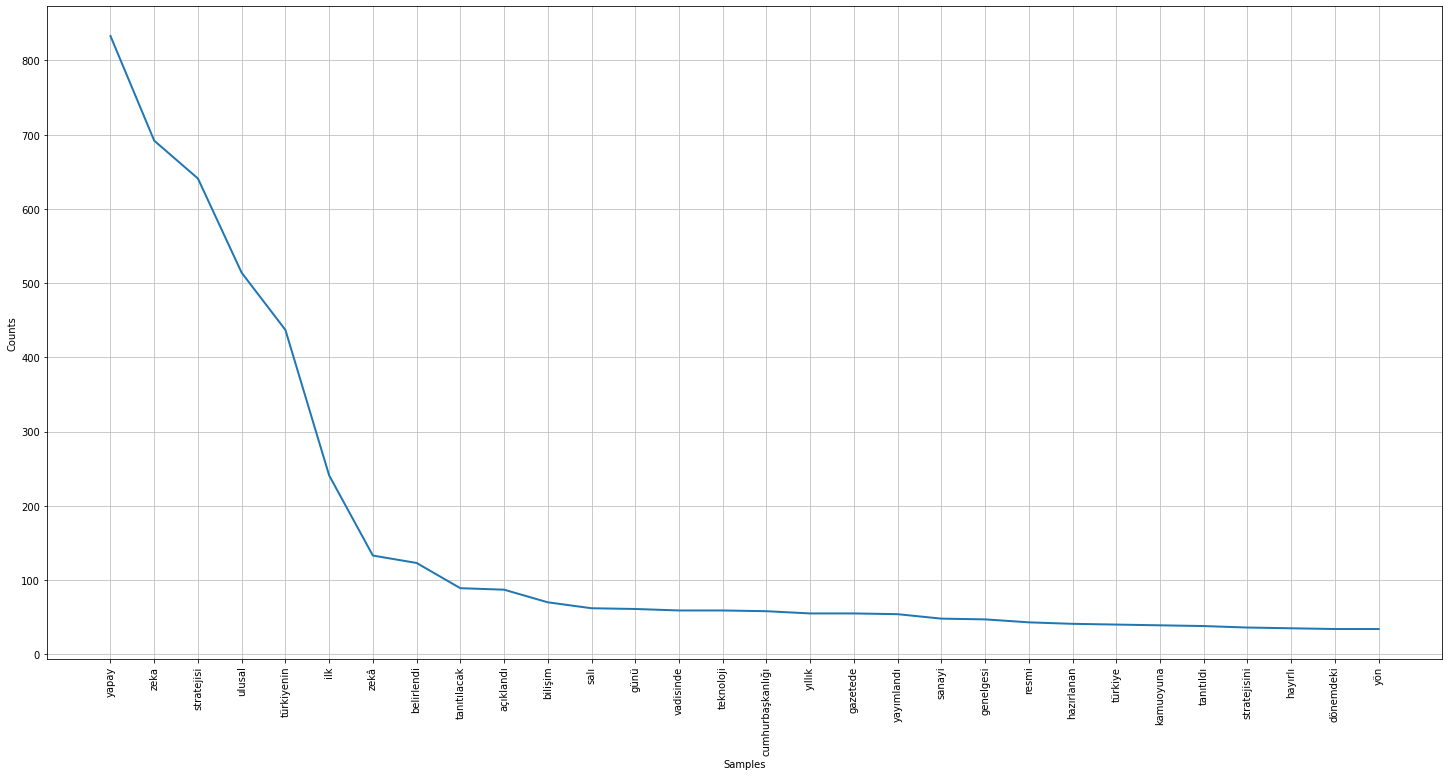

In [55]:
fdist_filtered = FreqDist(token_words_clean_)
#fdist_filtered.plot(30,title='Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')
plt.figure(figsize=(25, 12))
fdist_filtered.plot(30)

In [28]:
from collections import Counter

d = Counter(fdist_filtered)
d.most_common(30)

[('yapay', 833),
 ('zeka', 692),
 ('stratejisi', 641),
 ('ulusal', 514),
 ('türkiyenin', 437),
 ('ilk', 241),
 ('zekâ', 133),
 ('belirlendi', 123),
 ('tanıtılacak', 89),
 ('açıklandı', 87),
 ('bilişim', 70),
 ('salı', 62),
 ('günü', 61),
 ('vadisinde', 59),
 ('teknoloji', 59),
 ('cumhurbaşkanlığı', 58),
 ('yıllık', 55),
 ('gazetede', 55),
 ('yayımlandı', 54),
 ('sanayi', 48),
 ('genelgesi', 47),
 ('resmi', 43),
 ('hazırlanan', 41),
 ('türkiye', 40),
 ('kamuoyuna', 39),
 ('tanıtıldı', 38),
 ('stratejisini', 36),
 ('hayırlı', 35),
 ('dönemdeki', 34),
 ('yön', 34)]

### Word Cloud

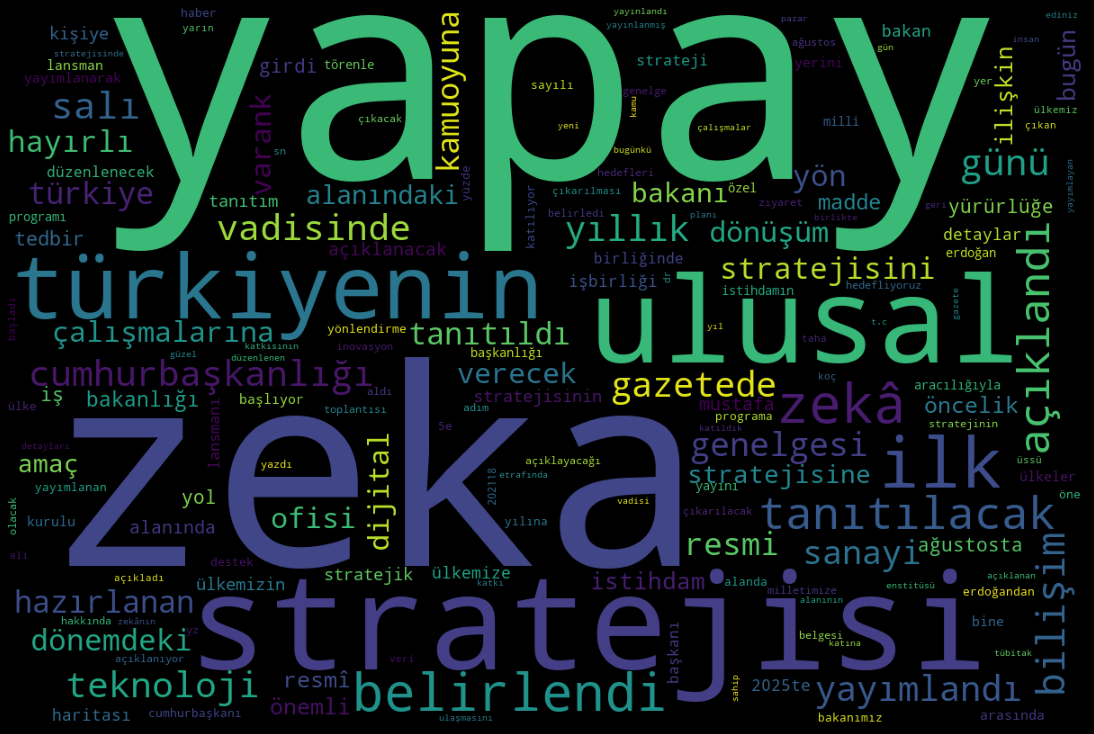

In [29]:
generate_word_cloud_from_frequencies(fdist_filtered, "all")

## POSITIVE

### Tokenizer

In [30]:
token_positive_words = word_tokenize(tweet_positive_texts)
print(token_positive_words)
print(len(token_positive_words))

['@', 'ZB6868', '@', 'firstjedii', '@', 'varank', 'Bence', 'biraz', 'absürd', 'bir', 'düşünce', 'bu', ':', ')', 'Yapay', 'zeka', 'şuan', 'hayatımızda', 'zaten', 'mevcut', 'aslında', '...', 'Bir', 'çok', 'alanda', 'da', 'kullanıyoruz', '.', 'Bizim', 'insanımızın', 'aklına', 'Yapay', 'Zeka', 'diyince', ',', 'insansı', 'robotlar', 'geliyor', '...', 'Ama', 'bu', 'öyle', 'bir', 'şey', 'değil', '.', 'Otonom', 'temelli', 'bir', 'yapay', 'zeka', 'stratejisi', 'konuşuluyor', ':', ')', 'Türkiye', ',', 'yapay', 'zekâ', 'stratejisini', 'yayımlayan', 'ülkeler', 'arasında', 'yerini', 'aldı', '!', '🇹🇷Türkiye', '’', 'nin', 'ilk', '“', 'Ulusal', 'Yapay', 'Zekâ', 'Stratejisi', '”', 'yayımlandı', '.', 'Ülkemize', 'hayırlı', 'olsun.👏🏻Teşekkürler', '@', 'dijital', '#', 'YapayZekaÇağı', 'https', ':', '//t.co/pSGZLl95KK', 'Ulusal', 'Yapay', 'Zeka', 'Stratejisi', 'Programı', ',', 'savunma', 'sanayiinde', 'yapılanlar', ',', "İHA'lar", ',', "SİHA'lar", ',', 'TOGG', ',', 'sel-yangın', 'afetlerinde', 'gösterilen'

### Cleaner

In [31]:
tweet_positive_texts_clean = preprocess_tweet(tweet_positive_texts)
tweet_positive_texts_clean

'bence biraz absürd bir düşünce bu   yapay zeka şuan hayatımızda zaten mevcut aslında bir çok alanda da kullanıyoruz  bizim insanımızın aklına yapay zeka diyince  insansı robotlar geliyor ama bu öyle bir şey değil  otonom temelli bir yapay zeka stratejisi konuşuluyor   türkiye  yapay zekâ stratejisini yayımlayan ülkeler arasında yerini aldı  türkiyenin ilk ulusal yapay zekâ stratejisi yayımlandı  ülkemize hayırlı olsun.teşekkürler ulusal yapay zeka stratejisi programı  savunma sanayiinde yapılanlar  ihalar  sihalar  togg  selyangın afetlerinde gösterilen üstün gayretler  covid mücadelesinde ve aşılamadaki başarı  yenilenenyeni hastaneler ve daha neler neler başlıyor ve işbirliği ile hazırlanan türkiyenin ilk ulusal yapay zeka stratejisi  türkiyenin nde bugün saat 10.00da açıklanacak  yapay zeka çaği ile işbirliğinde hazırlanan türkiyenin ilk ulusal yapay zekâ stratejisi  teknoloji ve inovasyon üssü tanıtıldı  adresinden ulaşabilirsiniz  başlıyor ve işbirliği ile hazırlanan türkiyenin i

In [32]:
token_positive_words_clean = word_tokenize(tweet_positive_texts_clean)
print(token_positive_words_clean)
print(len(token_positive_words_clean))

['bence', 'biraz', 'absürd', 'bir', 'düşünce', 'bu', 'yapay', 'zeka', 'şuan', 'hayatımızda', 'zaten', 'mevcut', 'aslında', 'bir', 'çok', 'alanda', 'da', 'kullanıyoruz', 'bizim', 'insanımızın', 'aklına', 'yapay', 'zeka', 'diyince', 'insansı', 'robotlar', 'geliyor', 'ama', 'bu', 'öyle', 'bir', 'şey', 'değil', 'otonom', 'temelli', 'bir', 'yapay', 'zeka', 'stratejisi', 'konuşuluyor', 'türkiye', 'yapay', 'zekâ', 'stratejisini', 'yayımlayan', 'ülkeler', 'arasında', 'yerini', 'aldı', 'türkiyenin', 'ilk', 'ulusal', 'yapay', 'zekâ', 'stratejisi', 'yayımlandı', 'ülkemize', 'hayırlı', 'olsun.teşekkürler', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'programı', 'savunma', 'sanayiinde', 'yapılanlar', 'ihalar', 'sihalar', 'togg', 'selyangın', 'afetlerinde', 'gösterilen', 'üstün', 'gayretler', 'covid', 'mücadelesinde', 've', 'aşılamadaki', 'başarı', 'yenilenenyeni', 'hastaneler', 've', 'daha', 'neler', 'neler', 'başlıyor', 've', 'işbirliği', 'ile', 'hazırlanan', 'türkiyenin', 'ilk', 'ulusal', 'yapay', '

### Clean Stop Words

In [33]:
token_positive_words_clean_ = [w for w in token_positive_words_clean if not w in stop_words]
print(token_positive_words_clean_)
print(len(token_positive_words_clean_))

['bence', 'absürd', 'düşünce', 'yapay', 'zeka', 'şuan', 'hayatımızda', 'mevcut', 'alanda', 'kullanıyoruz', 'insanımızın', 'aklına', 'yapay', 'zeka', 'diyince', 'insansı', 'robotlar', 'geliyor', 'otonom', 'temelli', 'yapay', 'zeka', 'stratejisi', 'konuşuluyor', 'türkiye', 'yapay', 'zekâ', 'stratejisini', 'yayımlayan', 'ülkeler', 'arasında', 'yerini', 'aldı', 'türkiyenin', 'ilk', 'ulusal', 'yapay', 'zekâ', 'stratejisi', 'yayımlandı', 'ülkemize', 'hayırlı', 'olsun.teşekkürler', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'programı', 'savunma', 'sanayiinde', 'yapılanlar', 'ihalar', 'sihalar', 'togg', 'selyangın', 'afetlerinde', 'gösterilen', 'üstün', 'gayretler', 'covid', 'mücadelesinde', 'aşılamadaki', 'başarı', 'yenilenenyeni', 'hastaneler', 'neler', 'neler', 'başlıyor', 'işbirliği', 'hazırlanan', 'türkiyenin', 'ilk', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'türkiyenin', 'bugün', 'açıklanacak', 'yapay', 'zeka', 'çaği', 'işbirliğinde', 'hazırlanan', 'türkiyenin', 'ilk', 'ulusal', 'yapay', '

### Words Frequency

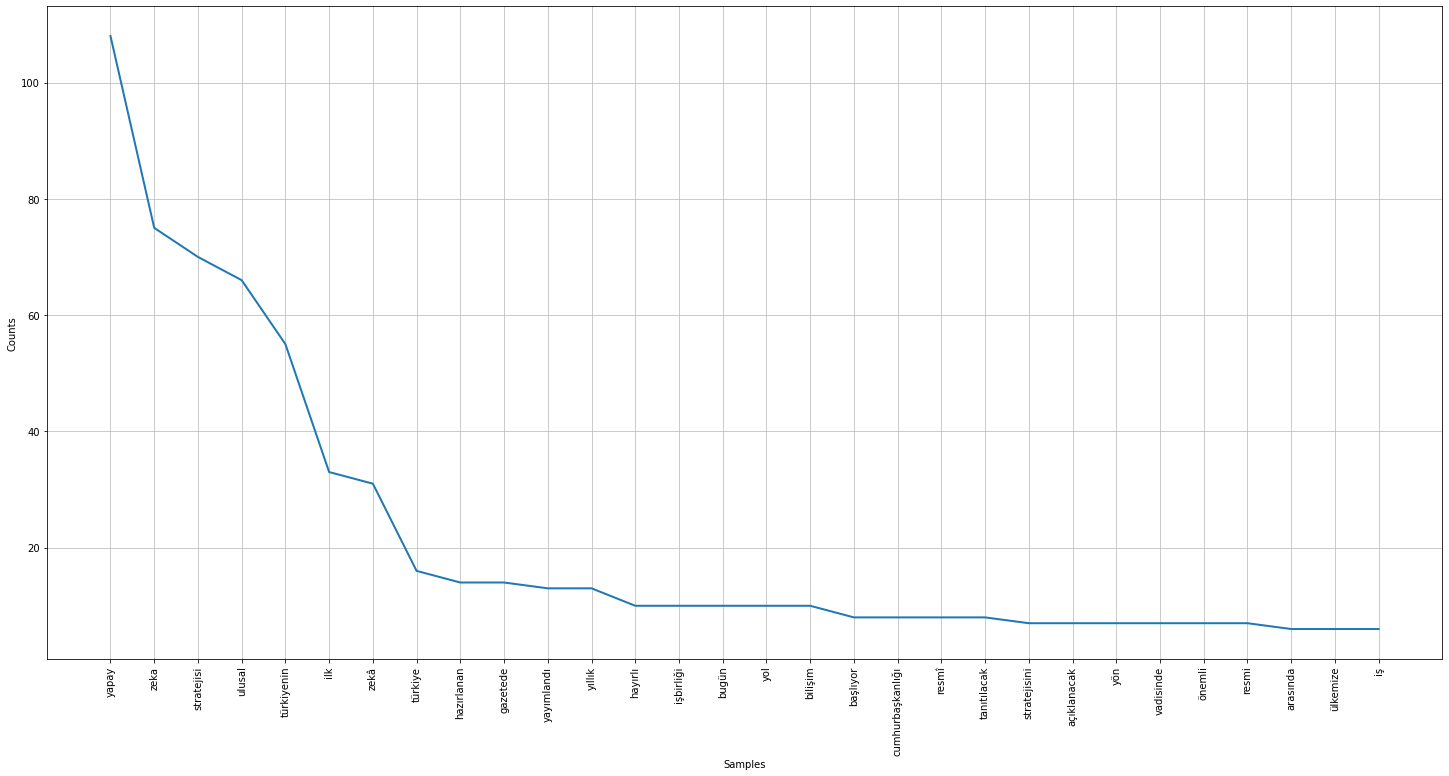

In [56]:
fdist_filtered_positive = FreqDist(token_positive_words_clean_)
#fdist_filtered_positive.plot(30,title='POSITIVE - Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')
plt.figure(figsize=(25, 12))
fdist_filtered_positive.plot(30)

In [35]:
d = Counter(fdist_filtered_positive)
d.most_common(30)

[('yapay', 108),
 ('zeka', 75),
 ('stratejisi', 70),
 ('ulusal', 66),
 ('türkiyenin', 55),
 ('ilk', 33),
 ('zekâ', 31),
 ('türkiye', 16),
 ('hazırlanan', 14),
 ('gazetede', 14),
 ('yayımlandı', 13),
 ('yıllık', 13),
 ('hayırlı', 10),
 ('işbirliği', 10),
 ('bugün', 10),
 ('yol', 10),
 ('bilişim', 10),
 ('başlıyor', 8),
 ('cumhurbaşkanlığı', 8),
 ('resmî', 8),
 ('tanıtılacak', 8),
 ('stratejisini', 7),
 ('açıklanacak', 7),
 ('yön', 7),
 ('vadisinde', 7),
 ('önemli', 7),
 ('resmi', 7),
 ('arasında', 6),
 ('ülkemize', 6),
 ('iş', 6)]

### Word Cloud

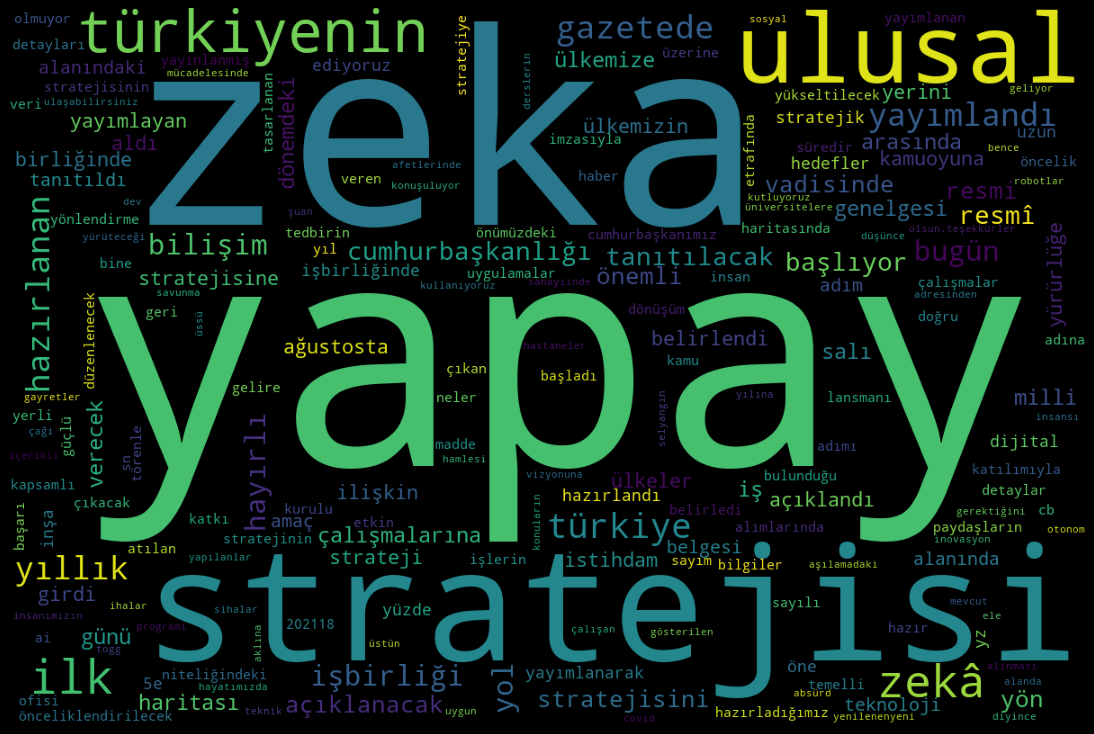

In [36]:
generate_word_cloud_from_frequencies(fdist_filtered_positive, "positive")

## NEGATIVE

### Tokenizer

In [37]:
token_negative_words = word_tokenize(tweet_negative_texts)
print(token_negative_words)
print(len(token_negative_words))

['Füsun', 'Sarp', 'Nebil', 'yazdı', ':', 'Yapay', 'zekâ', 'stratejisi', 'güzel', 'ama', 'altyapısı', 'yok', 'https', ':', '//t.co/Lm8ZFKjMgp', 'https', ':', '//t.co/EDrJo8mWVu', 'Sabırla', 'dinledim', 'konuşmaları', 've', 'çok', 'sığ', 'buldum', '!', 'Ülkenin', 'yapay', 'zeka', 'stratejisi', 'ya', 'da', 'vizyonuna', 'ilişkin', 'tek', 'bir', 'cümle', 'yok', '!', 'Yapay', 'zeka', 'dediğiniz', 'bir', 'algoritma', '!', 'Ülke', 'olarak', 'ihtiyacımız', 'olan', 'şey', 'milli', 'bir', 'İşletim', 'Sistemi..', '!', '1', 'Yıl', 'Önce', 'de', '1', 'Milyon', 'Yazılımcı', 'Yetiştireceğiz', 'Denilmişti', 'Nerede', 'O', 'Yazılımcılar', '?', 'Yapay', 'Zeka', 'Stratejisi', 'Açıklandı', 'da', 'Alt', 'Yapı', 'Nerede', '?', 'Veri', 'Merkezi', 'Nerede', '?', ')', '(', 'Ciddiyet', 'İsteyen', 'Konularda', 'Bile', 'Gevşeklik', ';', 'Olgudan', 'Çok', 'Uzak', 'Algı', ',', 'Tek', 'Dertleri', 'Oy', '...', 'https', ':', '//t.co/QYWZXyz3k9', 'Yapay', 'zeka', 'stratejisi', 'dokümanına', 'bakıyorduk', '.', 'Yapay', '

### Cleaner

In [38]:
tweet_negative_texts_clean = preprocess_tweet(tweet_negative_texts)
tweet_negative_texts_clean

'füsun sarp nebil yazdı  yapay zekâ stratejisi güzel ama altyapısı yok sabırla dinledim konuşmaları ve çok sığ buldum  ülkenin yapay zeka stratejisi ya da vizyonuna ilişkin tek bir cümle yok  yapay zeka dediğiniz bir algoritma  ülke olarak ihtiyacımız olan şey milli bir işletim sistemi  yıl önce de milyon yazılımcı yetiştireceğiz denilmişti nerede o yazılımcılar  yapay zeka stratejisi açıklandı da alt yapı nerede  veri merkezi nerede    ciddiyet isteyen konularda bile gevşeklik  olgudan çok uzak algı  tek dertleri oy yapay zeka stratejisi dokümanına bakıyorduk  yapay zeka daire başkanlığını görünce durduk  daire başkanı ibm watson olsun  makam odası  makam arabası  şoför  koruma  sekreter  çaycı  maaş  ikramiye  kıdem tazminatı istemez yapay zeka stratejisi güzel bir girişim olabilir  tarafsız gözle bakayım belki gerçekten bir çaba vardır diye oturdum lansmanı izledim  gözlemim  ya ingilizce nlp modellerine parmak ısırtan türkçe modeller var ya da bakan bildiğin dublörle sohbet ediyor 

In [39]:
token_negative_words_clean = word_tokenize(tweet_negative_texts_clean)
print(token_negative_words_clean)
print(len(token_negative_words_clean))

['füsun', 'sarp', 'nebil', 'yazdı', 'yapay', 'zekâ', 'stratejisi', 'güzel', 'ama', 'altyapısı', 'yok', 'sabırla', 'dinledim', 'konuşmaları', 've', 'çok', 'sığ', 'buldum', 'ülkenin', 'yapay', 'zeka', 'stratejisi', 'ya', 'da', 'vizyonuna', 'ilişkin', 'tek', 'bir', 'cümle', 'yok', 'yapay', 'zeka', 'dediğiniz', 'bir', 'algoritma', 'ülke', 'olarak', 'ihtiyacımız', 'olan', 'şey', 'milli', 'bir', 'işletim', 'sistemi', 'yıl', 'önce', 'de', 'milyon', 'yazılımcı', 'yetiştireceğiz', 'denilmişti', 'nerede', 'o', 'yazılımcılar', 'yapay', 'zeka', 'stratejisi', 'açıklandı', 'da', 'alt', 'yapı', 'nerede', 'veri', 'merkezi', 'nerede', 'ciddiyet', 'isteyen', 'konularda', 'bile', 'gevşeklik', 'olgudan', 'çok', 'uzak', 'algı', 'tek', 'dertleri', 'oy', 'yapay', 'zeka', 'stratejisi', 'dokümanına', 'bakıyorduk', 'yapay', 'zeka', 'daire', 'başkanlığını', 'görünce', 'durduk', 'daire', 'başkanı', 'ibm', 'watson', 'olsun', 'makam', 'odası', 'makam', 'arabası', 'şoför', 'koruma', 'sekreter', 'çaycı', 'maaş', 'ikr

### Clean Stop Words

In [40]:
token_negative_words_clean_ = [w for w in token_negative_words_clean if not w in stop_words]
print(token_negative_words_clean_)
print(len(token_negative_words_clean_))

['füsun', 'sarp', 'nebil', 'yazdı', 'yapay', 'zekâ', 'stratejisi', 'güzel', 'altyapısı', 'sabırla', 'dinledim', 'konuşmaları', 'sığ', 'buldum', 'ülkenin', 'yapay', 'zeka', 'stratejisi', 'vizyonuna', 'ilişkin', 'tek', 'cümle', 'yapay', 'zeka', 'dediğiniz', 'algoritma', 'ülke', 'ihtiyacımız', 'milli', 'işletim', 'sistemi', 'yıl', 'yazılımcı', 'yetiştireceğiz', 'denilmişti', 'yazılımcılar', 'yapay', 'zeka', 'stratejisi', 'açıklandı', 'alt', 'yapı', 'veri', 'merkezi', 'ciddiyet', 'isteyen', 'konularda', 'gevşeklik', 'olgudan', 'uzak', 'algı', 'tek', 'dertleri', 'oy', 'yapay', 'zeka', 'stratejisi', 'dokümanına', 'bakıyorduk', 'yapay', 'zeka', 'daire', 'başkanlığını', 'görünce', 'durduk', 'daire', 'başkanı', 'ibm', 'watson', 'makam', 'odası', 'makam', 'arabası', 'şoför', 'koruma', 'sekreter', 'çaycı', 'maaş', 'ikramiye', 'kıdem', 'tazminatı', 'istemez', 'yapay', 'zeka', 'stratejisi', 'güzel', 'girişim', 'olabilir', 'tarafsız', 'gözle', 'bakayım', 'gerçekten', 'çaba', 'vardır', 'oturdum', 'la

### Words Frequency

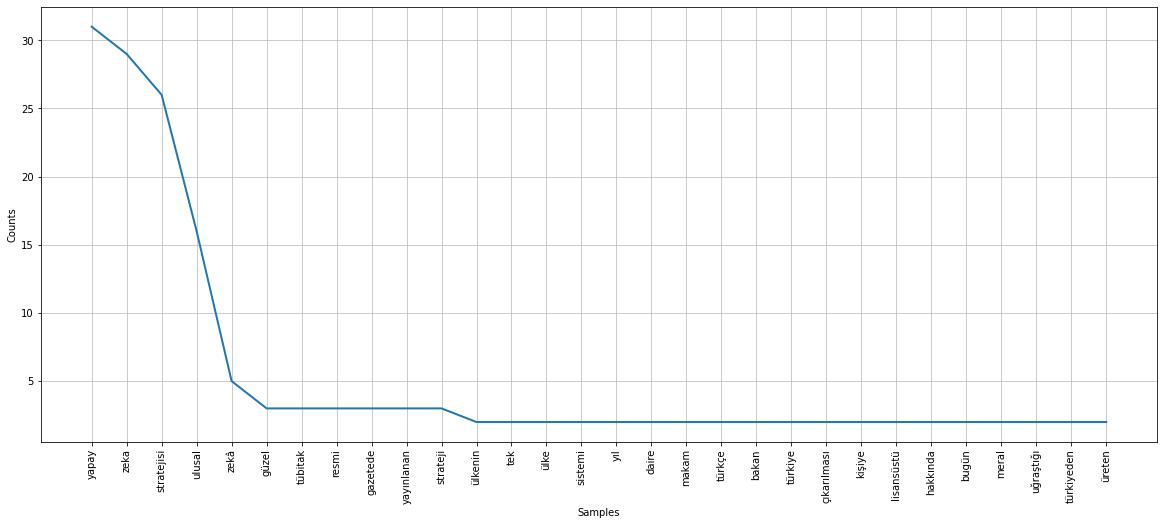

In [41]:
fdist_filtered_negative = FreqDist(token_negative_words_clean_)
#fdist_filtered_negative.plot(30,title='NEGATIVE - Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')
plt.figure(figsize=(20, 8))
fdist_filtered_negative.plot(30)

In [42]:
d = Counter(fdist_filtered_negative)
d.most_common(30)

[('yapay', 31),
 ('zeka', 29),
 ('stratejisi', 26),
 ('ulusal', 16),
 ('zekâ', 5),
 ('güzel', 3),
 ('tübitak', 3),
 ('resmi', 3),
 ('gazetede', 3),
 ('yayınlanan', 3),
 ('strateji', 3),
 ('ülkenin', 2),
 ('tek', 2),
 ('ülke', 2),
 ('sistemi', 2),
 ('yıl', 2),
 ('daire', 2),
 ('makam', 2),
 ('türkçe', 2),
 ('bakan', 2),
 ('türkiye', 2),
 ('çıkarılması', 2),
 ('kişiye', 2),
 ('lisansüstü', 2),
 ('hakkında', 2),
 ('bugün', 2),
 ('meral', 2),
 ('uğraştığı', 2),
 ('türkiyeden', 2),
 ('üreten', 2)]

### Word Cloud

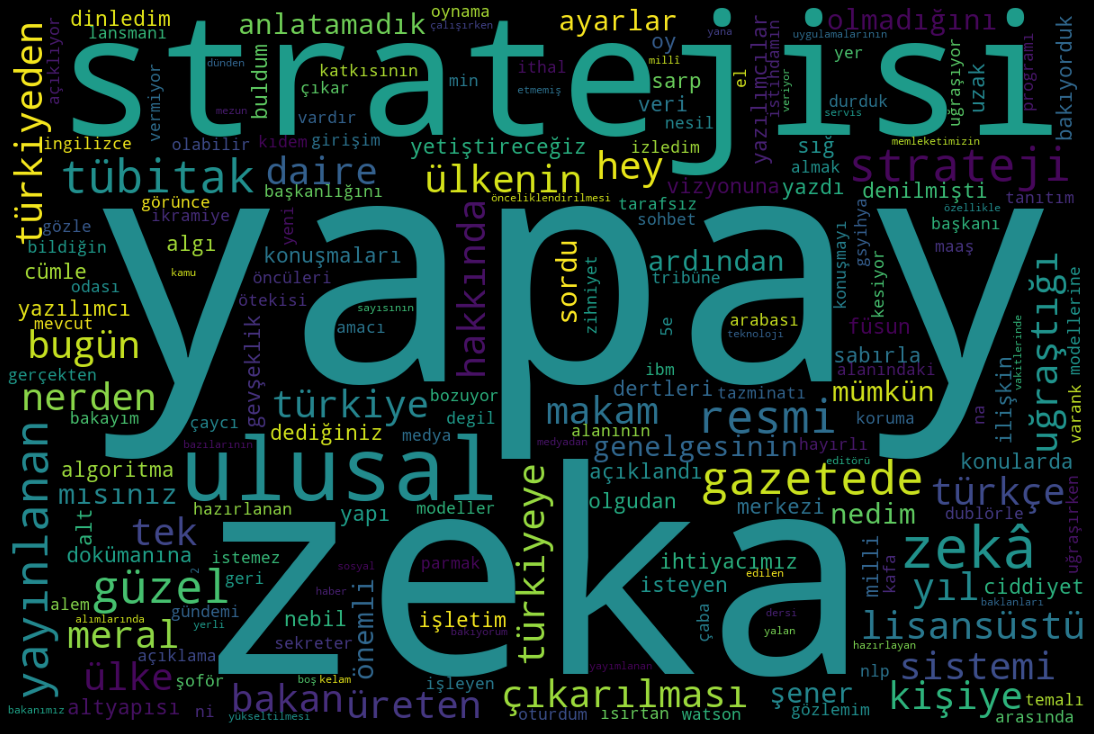

In [43]:
generate_word_cloud_from_frequencies(fdist_filtered_negative, "negative")

# DIFF

In [ ]:
diff_only_positive = set(token_positive_words) - set(token_negative_words)
diff_only_positive

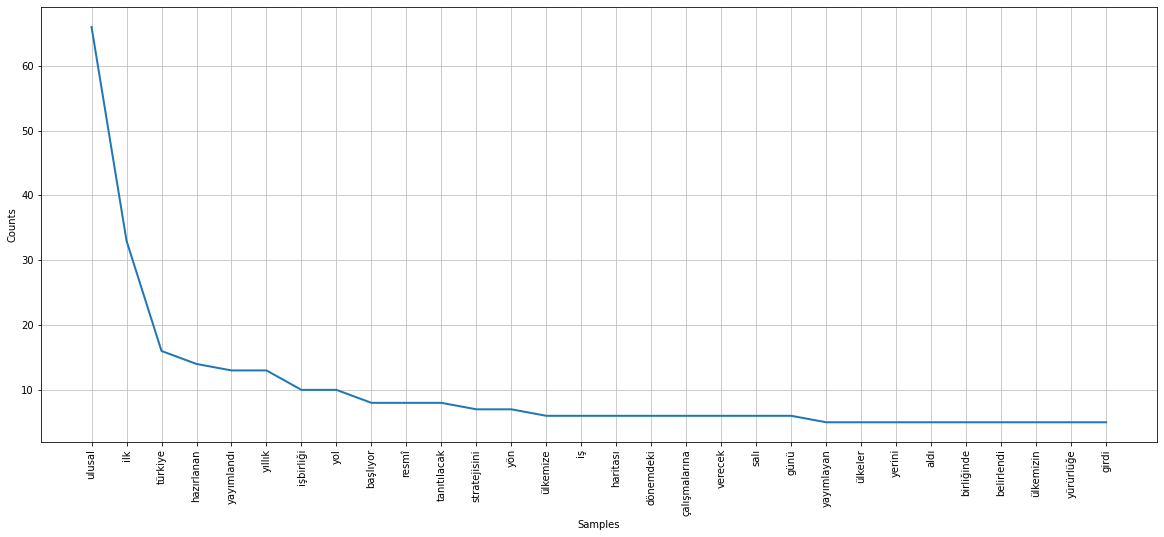

In [45]:
only_positive = []
for positive_word in token_positive_words_clean_:
  if positive_word in diff_only_positive:
    only_positive.append(positive_word)


fdist_filtered_only_positive = FreqDist(only_positive)
plt.figure(figsize=(20, 8))
fdist_filtered_only_positive.plot(30)

In [46]:
d = Counter(only_positive)
d.most_common(30)

[('ulusal', 66),
 ('ilk', 33),
 ('türkiye', 16),
 ('hazırlanan', 14),
 ('yayımlandı', 13),
 ('yıllık', 13),
 ('işbirliği', 10),
 ('yol', 10),
 ('başlıyor', 8),
 ('resmî', 8),
 ('tanıtılacak', 8),
 ('stratejisini', 7),
 ('yön', 7),
 ('ülkemize', 6),
 ('iş', 6),
 ('haritası', 6),
 ('dönemdeki', 6),
 ('çalışmalarına', 6),
 ('verecek', 6),
 ('salı', 6),
 ('günü', 6),
 ('yayımlayan', 5),
 ('ülkeler', 5),
 ('yerini', 5),
 ('aldı', 5),
 ('birliğinde', 5),
 ('belirlendi', 5),
 ('ülkemizin', 5),
 ('yürürlüğe', 5),
 ('girdi', 5)]

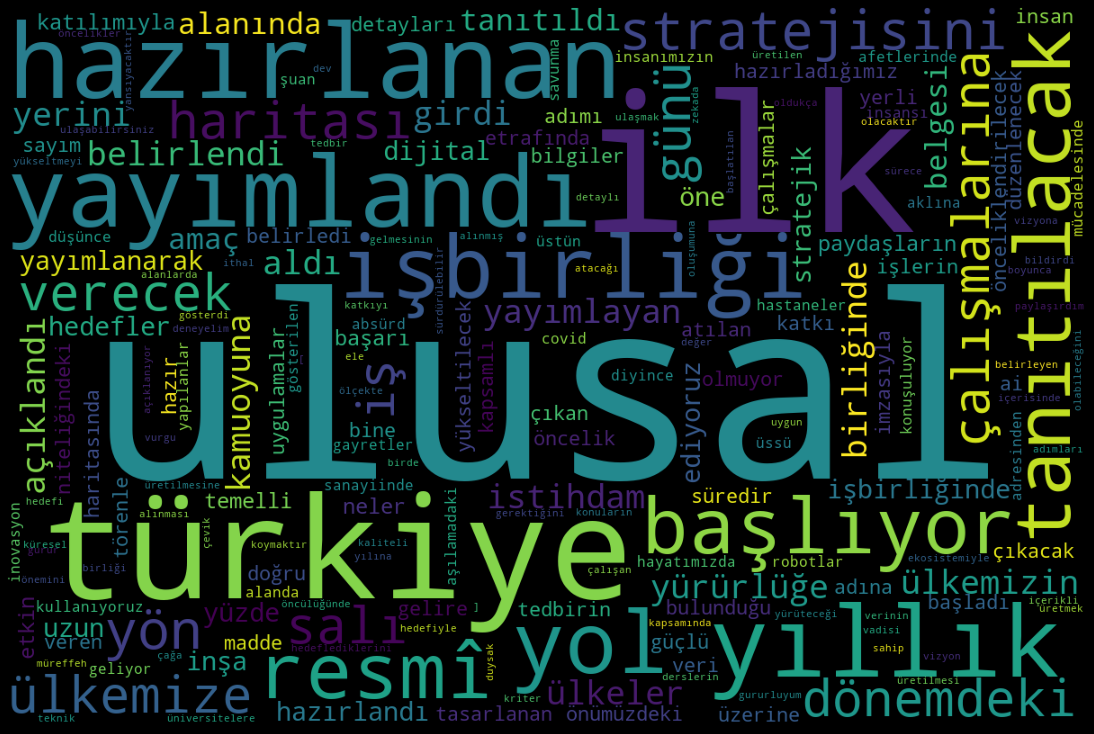

In [47]:
generate_word_cloud_from_frequencies(fdist_filtered_only_positive, "only_positive")

In [ ]:
diff_only_negative = set(token_negative_words) - set(token_positive_words)
diff_only_negative

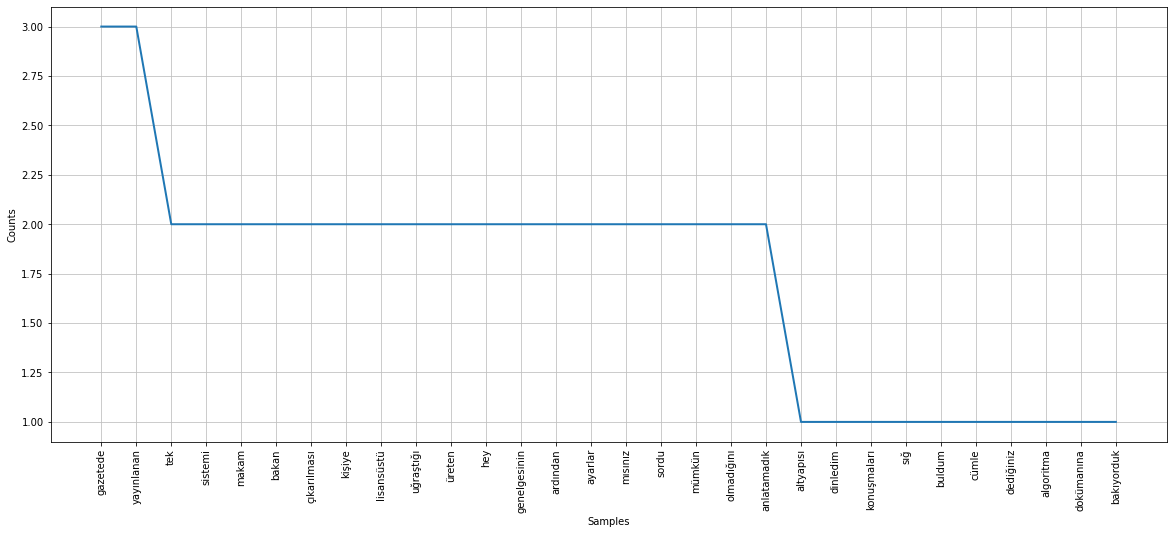

In [49]:
only_negative = []
for negative_word in token_negative_words_clean_:
  if negative_word in diff_only_negative:
    only_negative.append(negative_word)


fdist_filtered_only_negative = FreqDist(only_negative)
plt.figure(figsize=(20, 8))
fdist_filtered_only_negative.plot(30)

In [50]:
d = Counter(only_negative)
d.most_common(30)

[('gazetede', 3),
 ('yayınlanan', 3),
 ('tek', 2),
 ('sistemi', 2),
 ('makam', 2),
 ('bakan', 2),
 ('çıkarılması', 2),
 ('kişiye', 2),
 ('lisansüstü', 2),
 ('uğraştığı', 2),
 ('üreten', 2),
 ('hey', 2),
 ('genelgesinin', 2),
 ('ardından', 2),
 ('ayarlar', 2),
 ('mısınız', 2),
 ('sordu', 2),
 ('mümkün', 2),
 ('olmadığını', 2),
 ('anlatamadık', 2),
 ('altyapısı', 1),
 ('dinledim', 1),
 ('konuşmaları', 1),
 ('sığ', 1),
 ('buldum', 1),
 ('cümle', 1),
 ('dediğiniz', 1),
 ('algoritma', 1),
 ('dokümanına', 1),
 ('bakıyorduk', 1)]

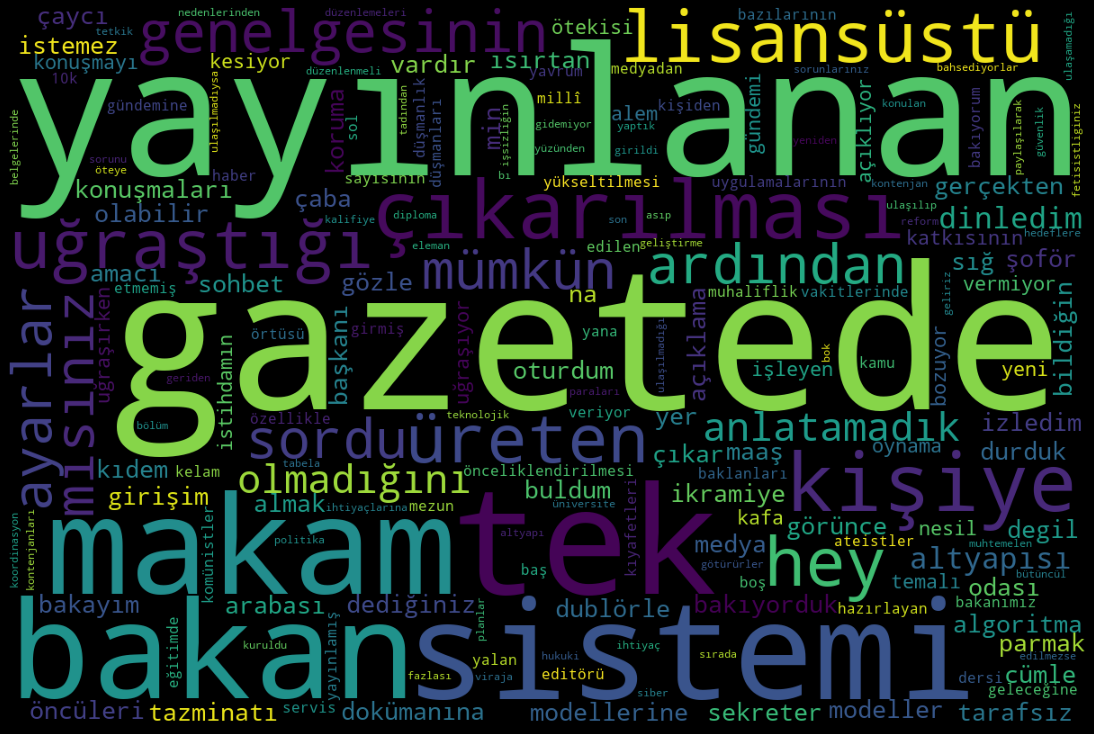

In [51]:
generate_word_cloud_from_frequencies(fdist_filtered_only_negative, "only_negative")